In [19]:
import torch
from sentence_transformers import SentenceTransformer
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import cv2

In [20]:
class SentenceEncoder:
    def __init__(self, device):
        self.bert_model = SentenceTransformer("all-mpnet-base-v2").to(device)
        self.device = device

    def convert_text_to_embeddings(self, batch_text):
        stack = []
        for sent in batch_text:
            l = sent.split(". ")
            sentence_embeddings = self.bert_model.encode(l)
            sentence_emb = torch.FloatTensor(
                sentence_embeddings).to(self.device)
            sent_mean = torch.mean(sentence_emb, dim=0).reshape(1, -1)
            stack.append(sent_mean)
        output = torch.cat(stack, dim=0)
        return output.detach()


In [21]:
sentence_encoder = SentenceEncoder('cpu')

In [28]:
def show_grid(img):
  npimg = img.numpy()
  plt. figure(figsize = (10,3))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [29]:
class Generator(nn.Module):
    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        self.projection = nn.Sequential(
            nn.Linear(in_features=embedding_size,
                      out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.layer = nn.Sequential(
            nn.ConvTranspose2d(noise_size + reduced_dim_size,
                               feature_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            # state size (ngf*4) x 4 x 4
            nn.ConvTranspose2d(
                feature_size * 8, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(
                feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(
                feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(feature_size, feature_size,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(feature_size, num_channels,
                               4, 2, 1, bias=False),
            nn.Tanh()
        )
        self.optimizer = torch.optim.Adam(
            self.parameters(), lr=0.0002, betas=(0.5, 0.5))

    def forward(self, noise, text_embeddings):
        encoded_text = self.projection(text_embeddings)
        concat_input = torch.cat(
            [noise, encoded_text], dim=1).unsqueeze(2).unsqueeze(2)
        output = self.layer(concat_input)
        return output

In [30]:
model = Generator(100, 128, 3, 768, 256)

In [31]:
model.load_state_dict(torch.load(
    'generator_50k.pth', map_location='cpu'))

model.eval()

Generator(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer): Sequential(
    (0): ConvTranspose2d(356, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

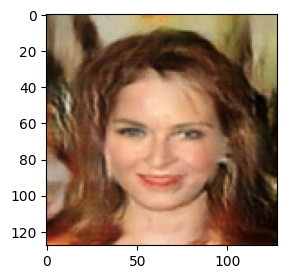

In [32]:
test_noise = torch.randn(size=(1, 100))
test_embeddings = sentence_encoder.convert_text_to_embeddings(["The female has pretty high cheekbones and an oval face. She has brown hair. She has arched eyebrows and a pointy nose. She is smiling, seems attractive, young, has rosy cheeks and heavy makeup. She is wearing earrings and lipstick."])
test_image = model(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

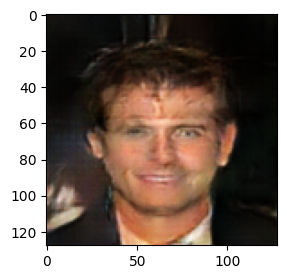

In [33]:
test_noise = torch.randn(size=(1, 100))
test_embeddings = sentence_encoder.convert_text_to_embeddings(["He wears a 5 o clock shadow. His hair is brown and straight. He has a slightly open mouth and a pointy nose. He looks attractive and young is smiling. He is wearing a necktie."])
test_image = model(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

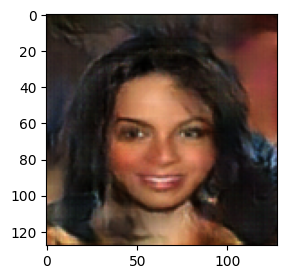

In [35]:
test_noise = torch.randn(size=(1, 100))
test_embeddings = sentence_encoder.convert_text_to_embeddings(["The female has high cheekbones. Her hair is black. She has arched eyebrows, a big nose and bushy eyebrows. The lady is young, is smiling and has heavy makeup. She is wearing lipstick and a necklace. "])
test_image = model(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))